In [1]:
%load_ext autoreload
%autoreload 2
from data.visualise import scatter_3d, scatter_yz, show_psf_axial, plot_with_sphere, grid_psfs
from data.datasets import ExperimentalDataSet, TrainingDataSet

from config.datasets import dataset_configs
from data.estimate_offset import remove_bg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
from functools import partial
from PIL import Image

from io import BytesIO

def showarray(a, fmt='png'):
    f = BytesIO()
    Image.fromarray(a).save(f, fmt)
    return f.getvalue()
    
plt.rcParams['figure.figsize'] = [3, 5]
dataset = '20220506_Miguel_beads_zeiss'
cfg = dataset_configs[dataset]['training_3']
cfg['csv'] = cfg['csv'].replace('_filtered', '')
ds = ExperimentalDataSet(cfg, transform_data=False, lazy=True)
ds.prepare_debug()

ds.filter_emitters_proximity = False
if 'id' not in list(ds.csv_data):
    ds.csv_data['id'] = list(range(ds.csv_data.shape[0]))

ROWS = 1000
COLS = 5
IMG_WIDTH, IMG_HEIGHT = 64, 64

n_psfs = ds.csv_data.shape[0]

psfs = []
ds.prepare_debug()
for i in range(n_psfs):
    psf, _, _, z, _ = ds.debug_emitter(i, 10000)
    idx = np.argmin(abs(z))
    psf = remove_bg(psf)
    psfs.append(psf[idx])
psfs = np.stack(psfs)
print(psfs.shape, n_psfs)
psfs *= 255 * 255
psfs = np.uint16(psfs)
psfs = [p for p in psfs]

selected_ids = set()
def on_click(*args, **kwargs):
    selected_ids.add(args[0])
    print(selected_ids)

def show_all_psfs():
    clear_output()
    n_psfs = ds.csv_data.shape[0]

    rows = []
    for row in range(ROWS):
        finished = False
        cols = []
        for col in range(COLS):
            index = row * COLS + col
            try:
                img = psfs[index]
                img = (img - img.min()) / (img.max() - img.min())
                img = (img*255*255).astype(np.uint16)
                im_data = showarray(img)
            except IndexError:
                finished = True
                break
            image = widgets.Image(
                value=im_data, width=IMG_WIDTH, height=IMG_HEIGHT
            )
            psf_id = ds.csv_data.iloc[index]['id']
            button = widgets.Button(description='Image %d' % psf_id)
            # Bind the click event to the on_click function, with our index as argument
            button.on_click(partial(on_click, psf_id))

            # Create a vertical layout box, image above the button
            box = widgets.VBox([image, button])
            cols.append(box)

        # Create a horizontal layout box, grouping all the columns together
        rows.append(widgets.HBox(cols))
        if finished:
            break
    # Create a vertical layout box, grouping all the rows together
    result = widgets.VBox(rows)
    display(result)
    
show_all_psfs()
    

<ipython-input-1-1334a49c87b3>:70: RuntimeWarning: invalid value encountered in true_divide
  img = (img - img.min()) / (img.max() - img.min())


Rows 9 Cols 10 n_spaces 90 n_psfs 86


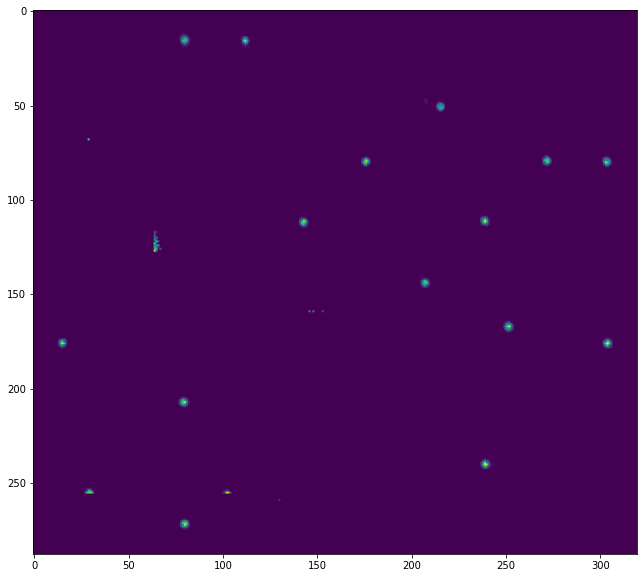

In [2]:
plt.imshow(grid_psfs(psfs))
plt.show()

In [3]:
print(ds.csv_data.shape)

selected_ids = [int(s) for s in sorted(selected_ids)]
if len(selected_ids) == 0:
    raise Exception
ds.csv_data = ds.csv_data[~ds.csv_data['id'].isin(selected_ids)]
# for i in sorted(selected_ids):
#     ds.csv_data.drop(i, inplace=True)

(86, 10)


Exception: 

In [4]:
import os
csv_path = os.path.join(cfg['bpath'], cfg['csv'].replace('.csv', '_filtered_2.csv'))
ds.csv_data.to_csv(csv_path)
print(csv_path)

/home/miguel/Projects/uni/data/smlm_3d/bead_3D_STORM_three_instruments/20210723_Olympus_beads/1mm_beads_agarose_centre_1/1mm_beads_agarose_centre_1_MMStack_Default_substack_filtered_2.csv
